In [3]:
import os
import time
import warnings
import collections

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
from utils.utilities import fetch_data, live_plot
from utils.td3 import Agent
from utils.envs import TradingEnv1, TradingEnv4, TradingEnv5, TradingEnv6, TradingEnv7

In [6]:
warnings.simplefilter('ignore')

In [7]:
%matplotlib inline

---

In [8]:
env_name = 'TradingEnv7'
db_name = './data/HistoricalPriceData.db'

seed = 42

In [9]:
torch.manual_seed(seed)
np.random.seed(seed)

##### Fetch the data

In [10]:
data = fetch_data(db_name)

In [11]:
# Don't include 2020 shock
for tick in data:
    data[tick] = data[tick][
        data[tick]['date'] <= pd.to_datetime('2020-02-01')
    ]

In [12]:
size = 520 # About two years
idx = np.random.randint(0, len(data['fb'])-size)

for t in data:
    data[t] = data[t].iloc[idx: idx+size]
    data[t].reset_index(drop=True, inplace=True)

In [13]:
print(idx)

1126


##### Initialize environment and set seeds

In [14]:
env = eval(f'{env_name}(data)')
env.seed(seed)

In [15]:
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Create folder in which trained models will be saved

In [16]:
if not os.path.exists('./models'):
    os.makedirs('./models')
if not os.path.exists('./models/all_td3'):
    os.makedirs('./models/all_td3')

In [17]:
file_name = f'TD3_{env_name}_{seed}'
print(file_name)

TD3_TradingEnv7_42


##### Initialize agent parameters

In [18]:
buffer_size = 1e6
batch_size = 100

gamma = 0.99
tau = 5e-3
policy_freq = 2
lr = 1e-3

policy_noise = 0.2
noise_clip = 0.5
expl_noise = 0.15

##### Initialize agent

In [19]:
agent = Agent(
    state_dim, 
    action_dim, 
    max_action,
    eta=lr,
)


---

##### Initialize training variables 

In [20]:
#agent.load(file_name, './models')

In [21]:
starting_step = 3e4 # Number of random steps at start

episodes = 1e3 # Number of episodes to train on
total_steps = 0
training = False
report = 50

In [22]:
positions = env.positions
print(positions)

('fb', 'amzn', 'aapl', 'msft', 'goog', '_out')


In [23]:
reward_trace = collections.defaultdict(list)

##### Training:

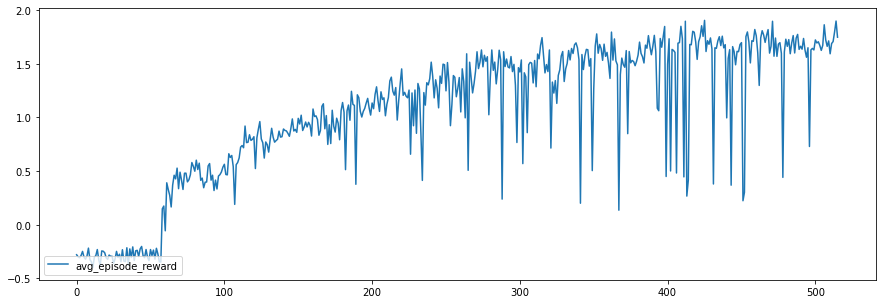

In [ ]:
for episode in np.arange(1, episodes):             
    
    obs = env.reset()
    done = False
    episode_reward = []
    steps = 0
    
    
    
    while not done:        
        
        if total_steps == starting_step:
            print('Begin training')
            training = True
            
        if not training:
            action = env.action_space.sample()
        else:
            action = agent.select_action(np.array(obs))
            
            if expl_noise != 0:
                noise = np.random.normal(0, expl_noise, size=env.action_space.shape[0])
                action = (action+noise).clip(env.action_space.low, env.action_space.high)
                
        action_fmt = env.format_action(positions, action)
                
        new_obs, reward, done, info = env.step(action_fmt)
        
        episode_reward.append(reward)
        agent.replay_buffer.add((obs, new_obs, action, reward, int(done)))
                
        obs = new_obs
        steps += 1
        total_steps += 1


        
    agent.train(steps, batch_size, gamma, tau, policy_noise, noise_clip, policy_freq)
    
    reward_trace['net_worth_diff'].append(sum(np.array(env.net_worth)-np.array(env.net_worth_long)))
    reward_trace['avg_episode_reward'].append(np.mean(episode_reward))
    reward_trace['sum_episode_reward'].append(sum(episode_reward))
    reward_trace['exploration_noise'].append(round(expl_noise, 9))
    
    ax = live_plot(reward_trace, trace='avg')                                                      ###
    plt.show()                                                                                     ###
    
    if episode % report == 0:
#        clear_output(wait=True)                                                                   ###
        
        print('Episode:', episode)
        print('Average net worth diff', np.mean(reward_trace['net_worth_diff'][-report:]))
        print('Average score:', np.mean(reward_trace['avg_episode_reward'][-report:]))
        print('Exploration noise:', reward_trace['exploration_noise'][-1])
        print('Training:', training)
        time.sleep(1)
        
        agent.save(
            f'{file_name}_{int(episode)}', 
            './models/all_td3',
        )
        

In [ ]:
total_steps

In [ ]:
episode

In [ ]:
expl_noise

---

##### Plot reward trace

In [ ]:
nwd = pd.Series(reward_trace['net_worth_diff'])
nwd = nwd.rolling(window=report, center=True, min_periods=1).mean()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['net_worth_diff'], 'b', alpha=0.7)
plt.plot(nwd, 'b')
plt.axvline(950, c='r')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['avg_episode_reward'], 'b')
plt.axvline(950, c='r')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(reward_trace['sum_episode_reward'], 'b')
plt.axvline(950, c='r')

plt.show()

##### Save only model from selected point in training history

In [ ]:
idx = 950

agent.load(
    f'{file_name}_{idx}', 
    './models/all_td3',
)

agent.save(
    file_name, 
    './models',
)

for item in os.listdir('./models/all_td3'):
    if file_name in str(item):
        os.remove(os.path.join('./models/all_td3', item))

In [ ]:
file_name